In [1]:
import pathlib
import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches
import mplstereonet
import skimage.exposure
import harmonica as hm
import verde as vd

import micromag as mg

In [2]:
# Ignore warnings coming from the Fourier transform module to avoid generating 100s of them.
import warnings
warnings.filterwarnings("ignore", module="xrft")

# Generate synthetic data

First, we create a regular grid of observation points.

In [3]:
sensor_sample_distance = 5.0  # µm
coordinates = vd.grid_coordinates(
    region=[0, 2000, 0, 2000],  # µm
    spacing=2,  # µm
    extra_coords=sensor_sample_distance,
)

Then, we create a low-frequency noise by simulating deeper dipole sources

In [4]:
deep_dipole_coordinates = (
    [ 300,  750, 1200, 300, 1200, 1750],  # µm
    [ 300, 1000, 1700, 1600, 300, 1000],  # µm
    [-600, -600, -600, -600, -600, -600],  # µm
)
deep_dipole_moments = mg.angles_to_vector(
    inclination=[-90, 90, -90, 90, 90, -90],
    declination=[0, 0, 0, 0, 0, 0],
    amplitude=[1.0E-10, 1.0E-10, 1.0E-10, 1.0E-10, 1.0E-10, 1.0E-10],
)

Now create the dipole model that will be used to generate the data.

In [5]:
# np.random.seed(0)
count_sources = np.arange(500, 5500, 500) #np.array([250, 500, 1000, 1500])  # #np.arange(100, 500, 100)
repetitions = np.arange(15)
models = []

for rep in repetitions:
    for sourcers in count_sources:
        np.random.seed(rep)
        dipole_coordinates = (
        np.random.randint(0, 2000, sourcers),  # µm
        np.random.randint(0, 2000, sourcers),  # µm
        np.random.randint(-20, -1, sourcers),  # µm
        ),
        dipole_moments = mg.angles_to_vector(
        inclination=np.random.normal(0, 10, sourcers),
        declination=np.random.normal(0, 10, sourcers),
        amplitude=abs(np.random.normal(0, 100, sourcers)*1.0E-14),
        )

        models.append((dipole_coordinates, dipole_moments))
    
# models[-1]

# print(models)

In [6]:
bz_regional = mg.dipole_bz(coordinates, deep_dipole_coordinates, deep_dipole_moments)
variable_name = []
for rep in repetitions:
    for count in count_sources:
        variable_name.append(f'bz_{count}_{rep}')

for (dipole_coordinates, dipole_moments), name in zip(models, variable_name):
    dipole_coordinates_ = (dipole_coordinates[0][0], dipole_coordinates[0][1], dipole_coordinates[0][2])
    
    bz = mg.dipole_bz(coordinates, dipole_coordinates_, dipole_moments)
    bz += mg.gaussian_noise(error=20, shape=(coordinates[1]).shape, seed=42)

    if name == variable_name[0]:
        data = vd.make_xarray_grid(coordinates, bz+bz_regional, data_names=[name], dims=("y", "x"), extra_coords_names="z")
        data.x.attrs = {"units": "µm"}
        data.y.attrs = {"units": "µm"}
        data[name].attrs = {"long_name": "vertical magnetic field", "units": "nT"} 
    else:
        dataset_aux = vd.make_xarray_grid(coordinates, bz+bz_regional, data_names=[name], dims=("y", "x"), extra_coords_names="z")
        dataset_aux[name].attrs = {"long_name": "vertical magnetic field", "units": "nT"} 
        
        data.update(dataset_aux)


In [7]:
data

<xarray.Dataset> Size: 1GB
Dimensions:     (y: 1001, x: 1001)
Coordinates:
  * x           (x) float64 8kB 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
  * y           (y) float64 8kB 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
    z           (y, x) float64 8MB 5.0 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0 5.0
Data variables: (12/150)
    bz_500_0    (y, x) float64 8MB -8.556 -38.2 -5.401 ... 49.81 66.91 58.61
    bz_1000_0   (y, x) float64 8MB -36.08 -69.16 -40.37 ... 59.58 77.57 70.1
    bz_1500_0   (y, x) float64 8MB -2.503e+03 -2.779e+03 ... 443.7 370.0
    bz_2000_0   (y, x) float64 8MB -105.4 -137.0 -106.1 ... 393.6 383.2 349.1
    bz_2500_0   (y, x) float64 8MB -2.259e+03 -2.923e+03 ... 96.95 85.85
    bz_3000_0   (y, x) float64 8MB -294.5 -352.0 -350.6 ... 2.788e+03 2.643e+03
    ...          ...
    bz_2500_14  (y, x) float64 8MB -351.2 -388.6 -363.4 ... 136.0 151.1 140.8
    bz_3000_14  (y, x) float64 8MB -4.375e+03 -5.502e+03 ... 1.147e+03 1.055e+03
    bz_3500_14  (y, x) float64 8MB -1.426e+03 -1.741e+03 ... 1.291e+04 1.118e+04
    bz_4000_14  (y, x) float64 8MB -8.366e+03 -9.301e+03 ... 3.61e+03 3.518e+03
    bz_4500_14  (y, x) float64 8MB -1.218e+03 -1.407e+03 ... 1.041e+04 9.104e+03
    bz_5000_14  (y, x) float64 8MB -589.1 -678.5 -714.2 ... 6.557e+03 5.483e+03

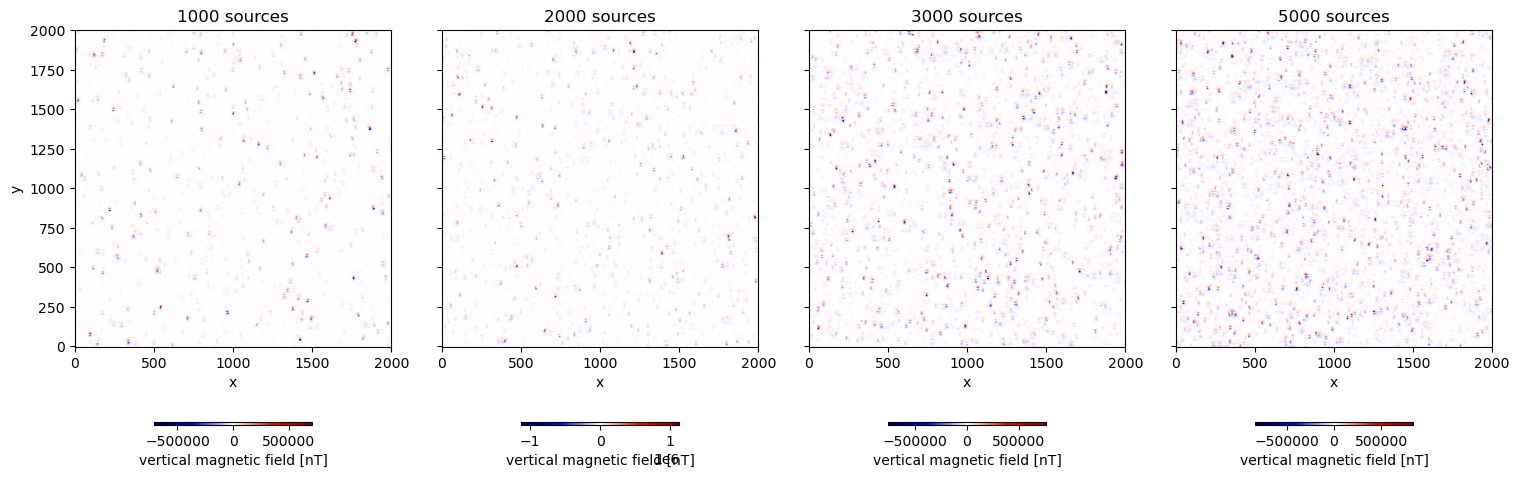

In [8]:
fig, axes = plt.subplots(1, 4, figsize=(15, 15), sharey="row")
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.05, shrink=0.5)

selected_name = ['bz_1000_1', 'bz_2000_1', 'bz_3000_1', 'bz_5000_1']

counter_sources_plot = np.empty((len(repetitions), len(count_sources)))

for i, s in enumerate(counter_sources_plot):
    counter_sources_plot[i] = count_sources


filtered_variables = [name for name in variable_name if name in selected_name] # filtering for the map plots
index_count_sources = [i for i,name in enumerate(variable_name) if name in selected_name]
counter_sources_plot = counter_sources_plot.ravel()


for field, ax, count in zip(filtered_variables, axes.ravel(), counter_sources_plot[index_count_sources]):
    data[field].plot.pcolormesh(ax=ax, cmap="seismic", cbar_kwargs=cbar_kwargs)
    ax.set_title(f'{int(count)} sources')
for ax in axes.ravel():
    ax.set_aspect("equal")
    
    
axes[1].set_ylabel(None)
axes[2].set_ylabel(None)
axes[3].set_ylabel(None)

plt.tight_layout(pad=0, h_pad=0, w_pad=2)


# selected_name = ['bz250', 'bz500', 'bz1000', 'bz1500']

# filtered_variables = [name for name in variable_name if name in selected_name]
# index_count_sources = [i for i,name in enumerate(variable_name) if name in selected_name]

# print(filtered_variables)
# print(index_count_sources)
# print(count_sources[index_count_sources])

# Anomaly detection

First part of our method is an automatic way to detect and separate the signal of each dipole in the data. This is done in the following steps:

1. Upward continue the data to suppress high frequency noise
2. Calculate the total gradient amplitude (TGA) to concentrate the anomalies on top of the sources
3. Contrast stretch the TGA to highlight weaker sources
4. Run the Laplacian of Gaussian (LoG) method for blog detection to find the anomalies

## 1. Upward continue the data to suppress the high-frequency noise

In this step, we want to upward continue as little as possible to make sure we retain most of the signal.

In [9]:
height_difference = 5

for name in variable_name:

    if name == variable_name[0]:
        data_up = (
            hm.upward_continuation(data[name], height_difference)
            .assign_attrs(data[name].attrs)
            .to_dataset(name=name)
            .assign_coords(x=data.x, y=data.y)
            .assign_coords(z=data.z + height_difference)
        )
    else:
        data_up_aux = (
            hm.upward_continuation(data[name], height_difference)
            .assign_attrs(data[name].attrs)
            .to_dataset(name=name)
            .assign_coords(x=data.x, y=data.y)
            .assign_coords(z=data.z + height_difference)
        )
        
        data_up.update(data_up_aux)

data_up


<xarray.Dataset> Size: 1GB
Dimensions:     (y: 1001, x: 1001)
Coordinates:
  * x           (x) float64 8kB 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
  * y           (y) float64 8kB 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
    z           (y, x) float64 8MB 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
Data variables: (12/150)
    bz_500_0    (y, x) float64 8MB -8.739 -12.51 -16.22 ... 19.94 14.42 7.944
    bz_1000_0   (y, x) float64 8MB 94.33 116.7 141.3 168.2 ... 75.03 87.53 106.9
    bz_1500_0   (y, x) float64 8MB 1.492e+03 1.835e+03 ... 931.1 1.201e+03
    bz_2000_0   (y, x) float64 8MB -1.387e+03 -953.1 ... -1.584e+03 -1.278e+03
    bz_2500_0   (y, x) float64 8MB 184.1 182.9 151.8 69.03 ... 156.7 242.5 336.9
    bz_3000_0   (y, x) float64 8MB 1.082e+03 1.115e+03 ... 1.697e+03 1.663e+03
    ...          ...
    bz_2500_14  (y, x) float64 8MB -299.3 -296.5 -296.3 ... -230.2 -219.0 -211.2
    bz_3000_14  (y, x) float64 8MB -1.57e+03 -2.112e+03 ... 0.2836 69.13
    bz_3500_14  (y, x) float64 8MB 2.987e+03 2.678e+03 ... 5.499e+03 4.86e+03
    bz_4000_14  (y, x) float64 8MB -762.0 -1.344e+03 ... 1.591e+03 1.386e+03
    bz_4500_14  (y, x) float64 8MB 1.743e+03 1.077e+03 ... 4.901e+03 3.845e+03
    bz_5000_14  (y, x) float64 8MB 2.138e+03 2.519e+03 ... 3.205e+03 3.241e+03

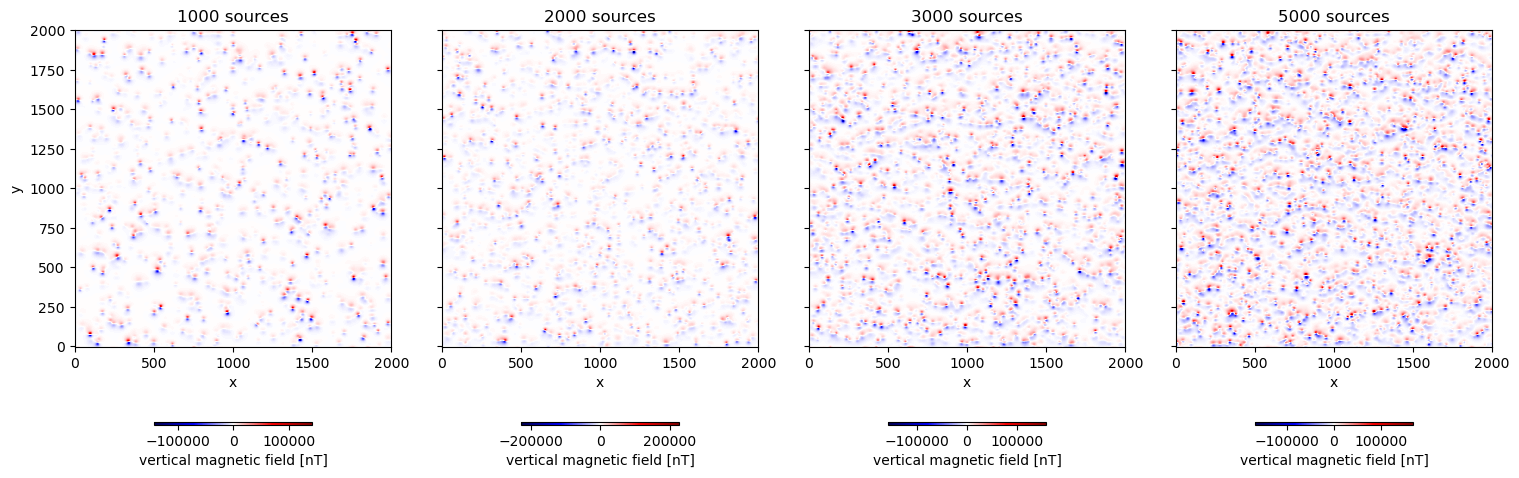

In [10]:
fig, axes = plt.subplots(1, 4, figsize=(15, 15), sharey="row")
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.05, shrink=0.5)

for field, ax, count in zip(filtered_variables, axes.ravel(), counter_sources_plot[index_count_sources]):
    if field in selected_name:
        data_up[field].plot.pcolormesh(ax=ax, cmap="seismic", cbar_kwargs=cbar_kwargs)
        ax.set_title(f'{int(count)} sources')
for ax in axes.ravel():
    ax.set_aspect("equal")
    
    
axes[1].set_ylabel(None)
axes[2].set_ylabel(None)
axes[3].set_ylabel(None)

plt.tight_layout(pad=0, h_pad=0, w_pad=2)

## 2. Calculate the TGA

We do this with finite difference derivatives to avoid amplifying noise.

In [11]:
# Modified data_gradients function for dealing with more than one maps
def data_gradients(data, prefix=None):
    """
    Add the derivatives and total gradient amplitude
    """
    dx = data.differentiate("x")
    dy = data.differentiate("y")
    spacing = np.mean([np.abs(data.x[1] - data.x[0]), np.abs(data.y[1] - data.y[0])])
    # Need to set the exact same coordinates because the xrft inverse transform
    # creates slightly different ones because of round-off errors.
    data_up = hm.upward_continuation(data, spacing).assign_coords(
        dict(x=data.x, y=data.y)
    )
    data_down = hm.upward_continuation(data, -spacing).assign_coords(
        dict(x=data.x, y=data.y)
    )
    # Forward difference only to avoid downward continuation.
    dz = (data_up - data_down) / (2 * spacing)
    tga = np.sqrt(dx**2 + dy**2 + dz**2)
    tga.attrs = {"long_name": "total gradient amplitude", "units": "nT/µm"}
    dx.attrs = {"long_name": "x-derivative", "units": "nT/µm"}
    dy.attrs = {"long_name": "y-derivative", "units": "nT/µm"}
    dz.attrs = {"long_name": "z-derivative", "units": "nT/µm"}
    return xr.Dataset({f"{prefix}_tga": tga, f"{prefix}_x_deriv": dx, f"{prefix}_y_deriv": dy, f"{prefix}_z_deriv": dz})


In [12]:
for name in variable_name:
    data_up = data_up.assign(data_gradients(data_up[name], prefix=name))
data_up

<xarray.Dataset> Size: 6GB
Dimensions:             (y: 1001, x: 1001)
Coordinates:
  * x                   (x) float64 8kB 0.0 2.0 4.0 ... 1.998e+03 2e+03
  * y                   (y) float64 8kB 0.0 2.0 4.0 ... 1.998e+03 2e+03
    z                   (y, x) float64 8MB 10.0 10.0 10.0 ... 10.0 10.0 10.0
Data variables: (12/750)
    bz_500_0            (y, x) float64 8MB -8.739 -12.51 -16.22 ... 14.42 7.944
    bz_1000_0           (y, x) float64 8MB 94.33 116.7 141.3 ... 87.53 106.9
    bz_1500_0           (y, x) float64 8MB 1.492e+03 1.835e+03 ... 1.201e+03
    bz_2000_0           (y, x) float64 8MB -1.387e+03 -953.1 ... -1.278e+03
    bz_2500_0           (y, x) float64 8MB 184.1 182.9 151.8 ... 242.5 336.9
    bz_3000_0           (y, x) float64 8MB 1.082e+03 1.115e+03 ... 1.663e+03
    ...                  ...
    bz_4500_14_y_deriv  (y, x) float64 8MB -496.6 -455.1 ... -692.2 -595.7
    bz_4500_14_z_deriv  (y, x) float64 8MB 17.08 28.81 2.425 ... -421.0 -304.7
    bz_5000_14_tga      (y, x) float64 8MB 640.1 658.5 712.4 ... 740.9 654.4
    bz_5000_14_x_deriv  (y, x) float64 8MB 190.9 201.9 222.1 ... -17.93 17.96
    bz_5000_14_y_deriv  (y, x) float64 8MB -610.2 -620.4 ... -689.9 -601.3
    bz_5000_14_z_deriv  (y, x) float64 8MB -30.22 -88.99 ... -269.5 -257.5

## 3. Stretch the contrast

Now we need to stretch the contrast of the TGA to make the anomalies easier to detect.

In [13]:
for name in variable_name:
    stretched = skimage.exposure.rescale_intensity(
        data_up[name+'_tga'], 
        in_range=tuple(np.percentile(data_up[name+'_tga'], (1, 99))),
    )

    tga_name = "tga_stretched_" + name
    tga = xr.DataArray(stretched, coords=data_up.coords)
    new_dataset = {tga_name: tga}
    data_up.update(new_dataset)
    
data_up

<xarray.Dataset> Size: 7GB
Dimensions:                   (y: 1001, x: 1001)
Coordinates:
  * x                         (x) float64 8kB 0.0 2.0 4.0 ... 1.998e+03 2e+03
  * y                         (y) float64 8kB 0.0 2.0 4.0 ... 1.998e+03 2e+03
    z                         (y, x) float64 8MB 10.0 10.0 10.0 ... 10.0 10.0
Data variables: (12/900)
    bz_500_0                  (y, x) float64 8MB -8.739 -12.51 ... 14.42 7.944
    bz_1000_0                 (y, x) float64 8MB 94.33 116.7 ... 87.53 106.9
    bz_1500_0                 (y, x) float64 8MB 1.492e+03 ... 1.201e+03
    bz_2000_0                 (y, x) float64 8MB -1.387e+03 ... -1.278e+03
    bz_2500_0                 (y, x) float64 8MB 184.1 182.9 ... 242.5 336.9
    bz_3000_0                 (y, x) float64 8MB 1.082e+03 ... 1.663e+03
    ...                        ...
    tga_stretched_bz_2500_14  (y, x) float64 8MB 0.001908 0.001868 ... 0.002553
    tga_stretched_bz_3000_14  (y, x) float64 8MB 0.07838 0.09776 ... 0.0718
    tga_stretched_bz_3500_14  (y, x) float64 8MB 0.06007 0.06077 ... 0.07441
    tga_stretched_bz_4000_14  (y, x) float64 8MB 0.09041 0.1121 ... 0.06613
    tga_stretched_bz_4500_14  (y, x) float64 8MB 0.04791 0.04307 ... 0.07152
    tga_stretched_bz_5000_14  (y, x) float64 8MB 0.0465 0.04809 ... 0.04774

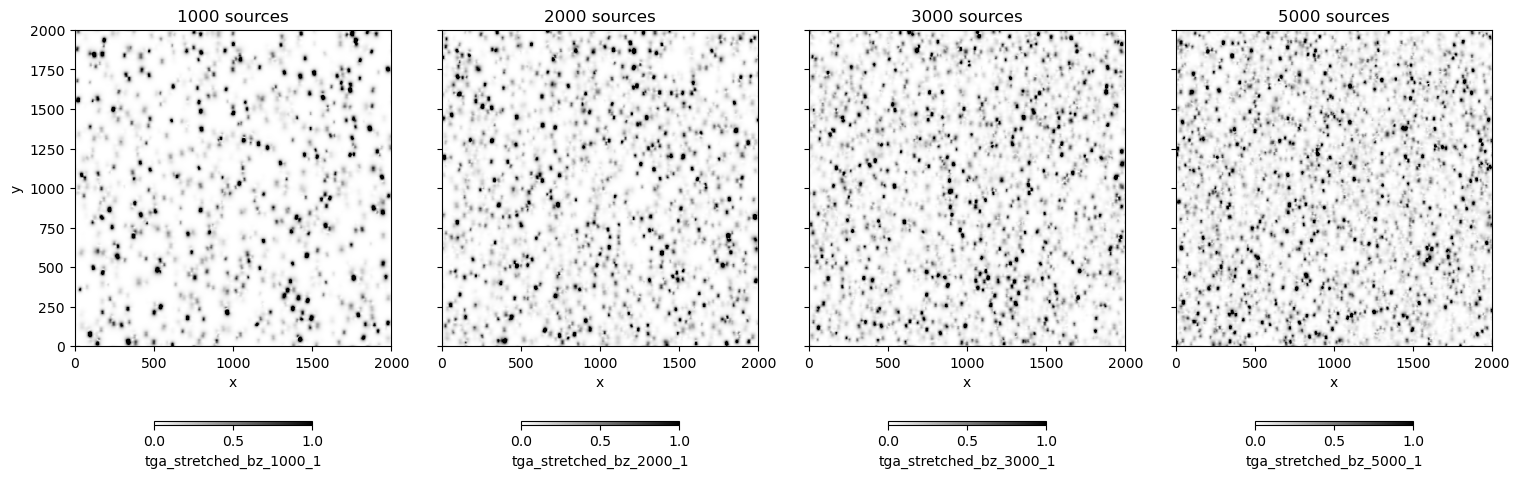

In [14]:
fig, axes = plt.subplots(1, 4, figsize=(15, 15), sharey="row")
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.05, shrink=0.5)

for field, ax, count in zip(filtered_variables, axes.ravel(), counter_sources_plot[index_count_sources]):
    data_up['tga_stretched_'+(field)].plot.pcolormesh(ax=ax, cmap="gray_r", cbar_kwargs=cbar_kwargs)
    ax.set_title(f'{int(count)} sources')
for ax in axes.ravel():
    ax.set_aspect("equal")
    
    
axes[1].set_ylabel(None)
axes[2].set_ylabel(None)
axes[3].set_ylabel(None)

plt.tight_layout(pad=0, h_pad=0, w_pad=2)

## 4. Blob detection

To detect the bounding boxes of each anomaly, we use the LoG method in scikit-image. The code below calls it with some conveniences, like passing the range of anomaly sizes in physical units (µm) instead of number of pixels. It returns the bounding box of each anomaly (x_min, x_max, y_min, y_max) also in physical units.

In [15]:
all_windows = []
for name in variable_name:
    tga_name = "tga_stretched_" + name

    windows = mg.detect_anomalies(
        data_up[tga_name], 
        size_range=[10, 50],
        size_increment=1.0,
        threshold=0.01,
        overlap=1.0,
        exclude_border=15
    )
    all_windows.append(windows)

In [16]:
for windows in all_windows:
    print('Sources detected: ', np.shape(windows)[0])

Sources detected:  409
Sources detected:  721
Sources detected:  1022
Sources detected:  1192
Sources detected:  1380
Sources detected:  1482
Sources detected:  1706
Sources detected:  1838
Sources detected:  1964
Sources detected:  2092
Sources detected:  411
Sources detected:  707
Sources detected:  989
Sources detected:  1200
Sources detected:  1391
Sources detected:  1606
Sources detected:  1737
Sources detected:  1810
Sources detected:  2004
Sources detected:  2102
Sources detected:  410
Sources detected:  765
Sources detected:  999
Sources detected:  1218
Sources detected:  1369
Sources detected:  1606
Sources detected:  1705
Sources detected:  1891
Sources detected:  1976
Sources detected:  2113
Sources detected:  416
Sources detected:  718
Sources detected:  985
Sources detected:  1176
Sources detected:  1369
Sources detected:  1583
Sources detected:  1688
Sources detected:  1880
Sources detected:  1977
Sources detected:  2048
Sources detected:  411
Sources detected:  724
Sourc

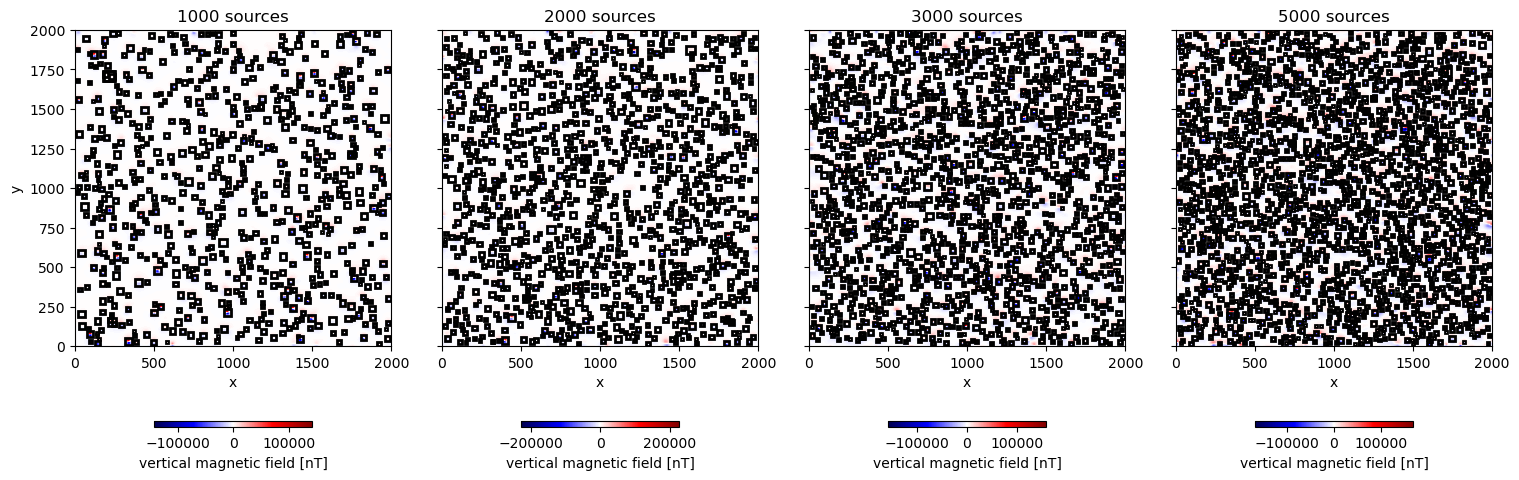

In [17]:
fig, axes = plt.subplots(1, 4, figsize=(15, 15), sharey="row")
cbar_kwargs = dict(orientation="horizontal", aspect=30, pad=0.05, shrink=0.5)

index_all_windows = [i for i,name in enumerate(variable_name) if name in selected_name]

# print(index_all_windows)
# for field, ax, count, windows in zip(filtered_variables, axes.ravel(), 
#                                      count_sources[index_count_sources], all_windows[index_all_windows]):
for field, ax, count, j in zip(filtered_variables, axes.ravel(), 
                                     counter_sources_plot[index_count_sources], np.array(index_all_windows)):
    windows = all_windows[j]
    
    data_up[field].plot.pcolormesh(ax=ax, cmap="seismic", cbar_kwargs=cbar_kwargs)
    ax.set_title(f'{int(count)} sources')
    for window in windows:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=2,
        )
        ax.add_patch(rect) 
    
for ax in axes.ravel():
    ax.set_aspect("equal")
    
axes[1].set_ylabel(None)
axes[2].set_ylabel(None)
axes[3].set_ylabel(None)

plt.tight_layout(pad=0, h_pad=0, w_pad=2)


Now that we know the bounding box of each anomaly, we can run the Euler deconvolution and moment inversion for each anomaly separately.

# Euler Deconvolution and Inversion

Run the Euler Deconvolution and the inversion on each window.

In [18]:
all_positions = []
all_estimated_dipole_moments = []
all_estimated_stds = []
all_calculated_r2 = []
all_calculated_SNR = []
all_windows_filtered = []

for name, windows in zip(variable_name, all_windows):
    positions = []
    estimated_dipole_moments = []
    estimated_stds = []
    calculated_r2 = []
    calculated_SNR = []
    windows_filtered = []
    base_levels = []
    
    for window in windows:
        anomaly = data_up.sel(x=slice(*window[:2]), y=slice(*window[2:]))
        position, base_level = mg.euler_deconvolution(
            anomaly[name], 
            anomaly[name+'_x_deriv'], 
            anomaly[name+'_y_deriv'], 
            anomaly[name+'_z_deriv'],
        )

        anomaly = data.sel(x=slice(*window[:2]), y=slice(*window[2:]))
        
        base_level = 0
        data_minus_background = anomaly[name].values                         #- base_level
        
        anomaly = anomaly.assign(data_minus_background=(['y','x'], data_minus_background))
        anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}

        moment, covariance, r2, SNR = mg.dipole_moment_inversion(
            anomaly.data_minus_background, position,
        )

        # Filter out solutions that don't meet quality criteria
        bad_euler = position[2] > 0
        poor_fit = False
#         r2_limit, SNR_limit = (0.95, 10)
#         poor_fit = (r2 < r2_limit) and (SNR > SNR_limit)
        if bad_euler or poor_fit:
            continue

        positions.append(position)  
        estimated_dipole_moments.append(moment)
        estimated_stds.append(mg.covariance_to_angle_std(moment, covariance))
        calculated_r2.append(r2)
        calculated_SNR.append(SNR)
        windows_filtered.append(window)
        base_levels.append(base_level)
    positions = np.transpose(positions)

    print()
    if poor_fit == False:
        print(f"{positions.shape[1]} dipole moments estimated")  
    else:
        print(f"{positions.shape[1]} dipole moments estimated with r2 = {r2_limit} and SNR = {SNR_limit}")    
    
    all_positions.append(positions)
    all_estimated_dipole_moments.append(estimated_dipole_moments)
    all_estimated_stds.append(estimated_stds)
    all_calculated_r2.append(calculated_r2)
    all_calculated_SNR.append(calculated_SNR)
    all_windows_filtered.append(windows_filtered)




408 dipole moments estimated

715 dipole moments estimated

1019 dipole moments estimated

1185 dipole moments estimated

1363 dipole moments estimated

1467 dipole moments estimated

1690 dipole moments estimated

1812 dipole moments estimated

1936 dipole moments estimated

2044 dipole moments estimated

410 dipole moments estimated

704 dipole moments estimated

982 dipole moments estimated

1193 dipole moments estimated

1375 dipole moments estimated

1588 dipole moments estimated

1716 dipole moments estimated

1783 dipole moments estimated

1978 dipole moments estimated

2069 dipole moments estimated

409 dipole moments estimated

760 dipole moments estimated

988 dipole moments estimated

1206 dipole moments estimated

1361 dipole moments estimated

1585 dipole moments estimated

1681 dipole moments estimated

1866 dipole moments estimated

1942 dipole moments estimated

2077 dipole moments estimated

415 dipole moments estimated

714 dipole moments estimated

980 dipole moment

Compare the Euler Deconvolution estimated position on each window to the source true positions.

In [19]:
all_closest = []
all_z_difference = []

for (dipole_coordinates, dipole_moments), name, positions in zip(models, variable_name, all_positions):
    
    dipole_coordinates_ = (dipole_coordinates[0][0], dipole_coordinates[0][1], dipole_coordinates[0][2])

    tree = sp.spatial.KDTree(np.transpose(dipole_coordinates_))
    closest = tree.query(np.transpose(positions))[1]
    z_difference = positions[2] - np.array(dipole_coordinates_[2])[closest]
    
    all_closest.append(closest)
    all_z_difference.append(z_difference)

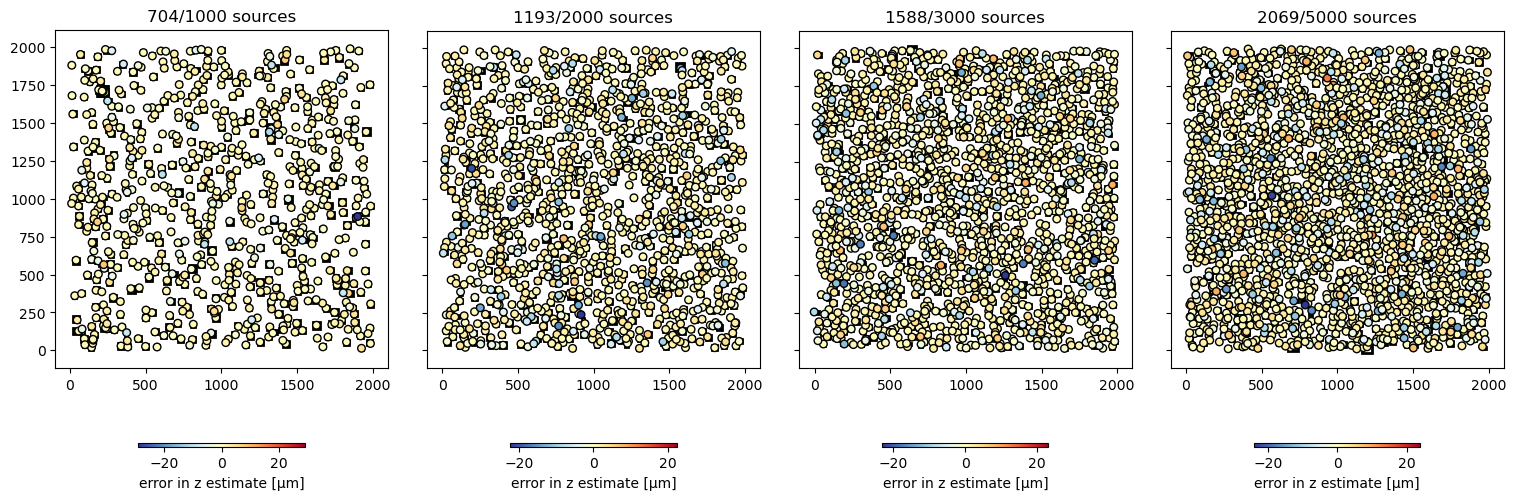

In [20]:
fig, axes = plt.subplots(1, 4, figsize=(15, 15), sharey="row", sharex='col')
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.05, shrink=0.5)

index_all_windows_filtered = [i for i,name in enumerate(variable_name) if name in selected_name]

# for field, ax, count, windows, positions, z_difference in zip(
#     variable_name, axes.ravel(),count_sources, all_windows_filtered, all_positions, all_z_difference):

for field, ax, count, j in zip(
    filtered_variables, axes.ravel(),counter_sources_plot[index_count_sources], index_all_windows_filtered):
    
    windows = all_windows_filtered[j]
    positions = all_positions[j]
    z_difference = all_z_difference[j]
#     data_up[field].plot.pcolormesh(ax=ax, cmap="seismic", cbar_kwargs=cbar_kwargs)
    ax.set_title(f'{np.shape(windows)[0]}/{int(count)} sources')
    for window in windows:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=2,
        )
        ax.add_patch(rect) 

    scale = vd.maxabs(z_difference)
    tmp = ax.scatter(*positions[:2], c=z_difference, cmap="RdYlBu_r", vmin=-scale, vmax=scale, s=30, edgecolor='k')
    fig.colorbar(tmp, **cbar_kwargs, label="error in z estimate [µm]")

for ax in axes.ravel():
    ax.set_aspect("equal")
    
axes[1].set_ylabel(None)
axes[2].set_ylabel(None)
axes[3].set_ylabel(None)

plt.tight_layout(pad=0, h_pad=0, w_pad=2)

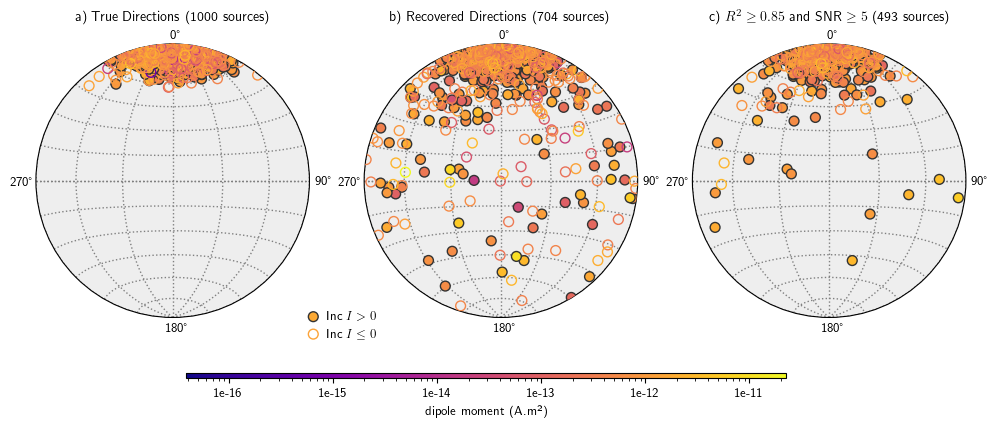

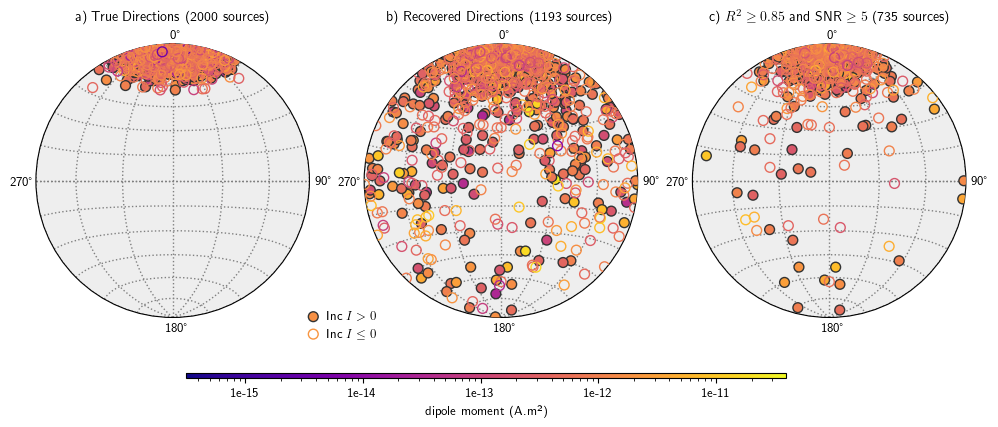

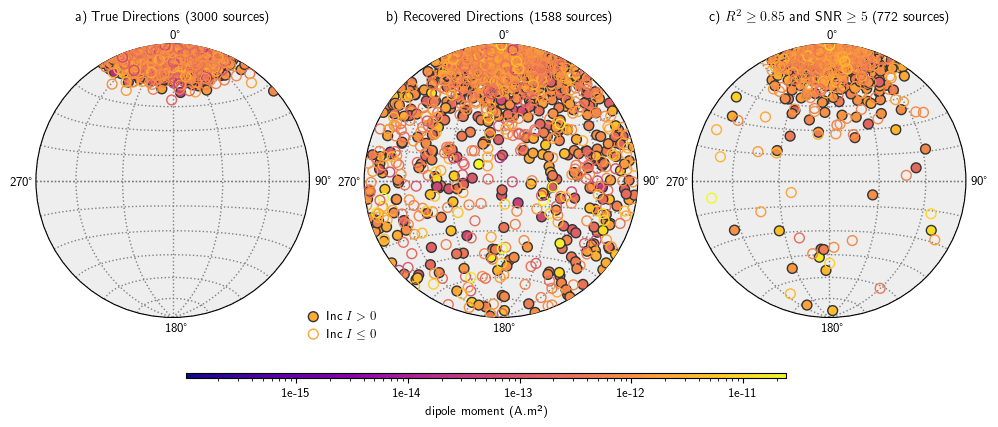

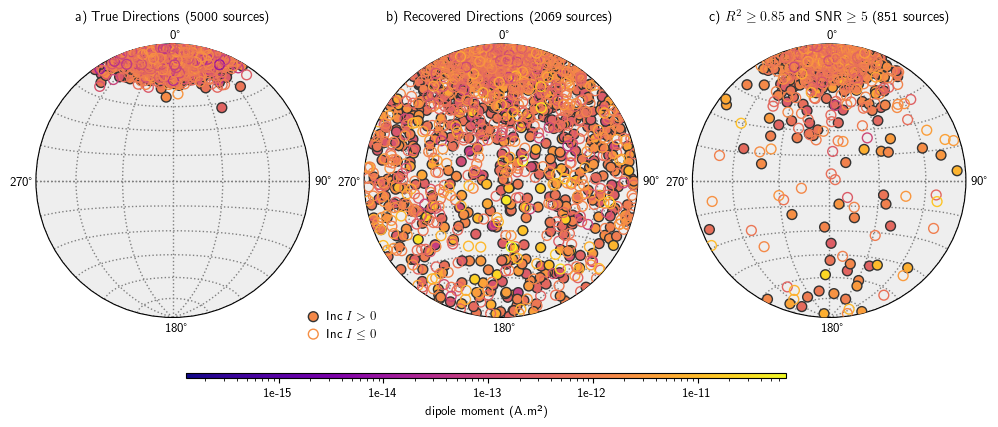

In [36]:
mpl_rc = {"text.usetex": True, "font.family": "serif", "font.size": 9}

with plt.rc_context(mpl_rc):
    
    for (_, dipole_moments), estimated_dipole_moments, calculated_r2, calculated_SNR, name,  in zip(
        models, all_estimated_dipole_moments, all_calculated_r2, all_calculated_SNR, variable_name):
        
        
        if name in selected_name:
            fig = plt.figure(figsize=(12, 5))
            axes = []


            #############
            ax = fig.add_subplot(1, 3, 1, projection='stereonet')
            axes.append(ax)    
            estimated = mg.vector_to_angles(estimated_dipole_moments)[2]
            true = mg.vector_to_angles(dipole_moments)[2]
            vmin = np.min((np.min(estimated), np.min(true)))
            vmax = np.max((np.max(estimated), np.max(true)))
            cmap = "plasma"
            # Use matplotlib.colors.LogNorm for a log scale
            cmap_norm = matplotlib.colors.LogNorm #Normalize
            kwargs = dict(
                ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
            )    
            tmp = mg.plot_stereonet(dipole_moments, marker="o", zorder=2000, **kwargs)



            #############
            ax = fig.add_subplot(1, 3, 2, projection='stereonet')
            axes.append(ax)    

            kwargs = dict(
                ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
            )    
            tmp = mg.plot_stereonet(estimated_dipole_moments, marker="o", zorder=1000, label="Inc", **kwargs)
            ax.legend(loc=(-0.25, -0.1), frameon=False, handletextpad=0.1)
            fig.colorbar(
                tmp, 
                cax=fig.add_axes([0.25, 0.1, 0.5, 0.01]), 
                format="%.0g",
                label="dipole moment (A.m²)",
                orientation="horizontal",
            )

            r2_limit, SNR_limit = (0.85, 5)
            pos_filter= ( (np.array(calculated_r2) > r2_limit) & (np.array(calculated_SNR) > SNR_limit))

            filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments)[:,0][pos_filter], 
                                              np.array(estimated_dipole_moments)[:,1][pos_filter], 
                                              np.array(estimated_dipole_moments)[:,2][pos_filter]
                                             ]).T


            ############
            ax = fig.add_subplot(1, 3, 3, projection='stereonet')
            axes.append(ax)    

            kwargs = dict(
                ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
            )    
            tmp = mg.plot_stereonet(filter_estimated_d_m, marker="o", zorder=1000, **kwargs)

            titles = (f'a) True Directions ({len(dipole_moments)} sources)', 
                      f'b) Recovered Directions ({len(estimated_dipole_moments)} sources)', 
                      f'c) $R^2 \geq {r2_limit}$ and SNR $\geq {SNR_limit}$ ({len(filter_estimated_d_m[:,2])} sources)')

            for ax, letter, title in zip(axes, "a b c".split(), titles):
    #             ax.text(0.1, 1.1, f"{letter})   ", transform=ax.transAxes, fontsize=10)
                ax.set_azimuth_ticks([])
                ax.grid(linestyle=':', color='gray')
                ax.set_title(title+'\n', fontsize=10, loc='center')
            fig.subplots_adjust(wspace=0.2)

plt.show()

In [22]:
# teste = (np.sum(all_estimated_dipole_moments[1], axis=0))

In [23]:
# mg.vector_to_angles(teste)

In [24]:
def angule_misfit(inc_1, dec_1, inc_2, dec_2):
    
    vector_1 = mg.angles_to_vector(inc_1, dec_1, 1)
    vector_2 = mg.angles_to_vector(inc_2, dec_2, 1)
    
    # calculating dot product
    dot_product = np.dot(vector_1, vector_2)

    # calculating angles in radians
    cos_theta = dot_product
    theta_rad = np.arccos(cos_theta)

    # converting to degrees
    theta_deg = float(np.degrees(theta_rad))
    
    return(np.round(theta_deg, 2))  

In [25]:
unfiltered_misfit = []
filtered_misfit   = []
unfiltered_ident_perc = []
filtered_ident_perc   = []

for (_, true_dipoles), estimated_dipoles, calculated_r2, calculated_SNR in zip(
    models, all_estimated_dipole_moments, all_calculated_r2, all_calculated_SNR):
    
    # true direction
    sum_vector_true = (np.sum(np.array(true_dipoles), axis=0))
    inc, dec, _ = mg.vector_to_angles(sum_vector_true)
    
    # estimated direction
    sum_vector_est = (np.sum(np.array(estimated_dipoles), axis=0))
    est_inc, est_dec, _ = mg.vector_to_angles(sum_vector_est)
    
    # filtered estimated direction
    filter= ( (np.array(calculated_r2) >= r2_limit) & (np.array(calculated_SNR) >= SNR_limit))
    
    sum_vector_filter = (np.sum(np.array(estimated_dipoles)[filter], axis=0))
    est_inc_filter, est_dec_filtered, _ = mg.vector_to_angles(sum_vector_filter)
    
#     print(f'True:              {np.round(dec,3)}° / {np.round(inc,3)}°')
#     print(f'Estimated          {np.round(est_dec,3)}° / {np.round(est_inc,3)}°')
#     print(f'Estimated (filter) {np.round(est_dec_filtered,3)}° / {np.round(est_inc_filter,3)}°')
#     print()
    
#     dir_misfit = float(np.degrees(mplstereonet.angular_distance(
#                             mplstereonet.line(inc, dec), mplstereonet.line(est_inc, est_dec), bidirectional=False))) # degrees
    
#     dir_misfit_filter = float(np.degrees(mplstereonet.angular_distance(
#                             mplstereonet.line(inc, dec), mplstereonet.line(est_inc_filter, est_dec_filtered), bidirectional=False))) # degrees
    
    
    
    dir_misfit = angule_misfit(inc, dec, est_inc, est_dec)
    dir_misfit_filter = angule_misfit(inc, dec, est_inc_filter, est_dec_filtered)
    
    unfiltered_perc = np.shape(estimated_dipoles)[0]*100/np.shape(true_dipoles)[0]
    unfiltered_ident_perc.append(np.round(unfiltered_perc,3))
    
    filtered_perc = np.shape(np.array(estimated_dipoles)[filter])[0]*100/np.shape(true_dipoles)[0]
    filtered_ident_perc.append(np.round(filtered_perc,3))


    unfiltered_misfit.append(dir_misfit)
    filtered_misfit.append(dir_misfit_filter)

In [26]:
shape = (len(repetitions), len(count_sources))

unfiltered_ident_perc = np.reshape(unfiltered_ident_perc, shape)
filtered_ident_perc = np.reshape(filtered_ident_perc, shape)

unfiltered_misfit = np.reshape(unfiltered_misfit, shape)
filtered_misfit = np.reshape(filtered_misfit, shape)

print(np.shape(filtered_misfit))

(15, 10)


In [27]:
volume_mm2 = (2*2*(20/1000))

fig_dir = pathlib.Path("..") / "paper" / "figures"
mpl_rc = {"text.usetex": True, "font.family": "serif", "font.size": 9}

In [28]:
def remove_outliers(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return [x for x in data if lower_bound <= x <= upper_bound]

# Remova outliers dos dados
# 

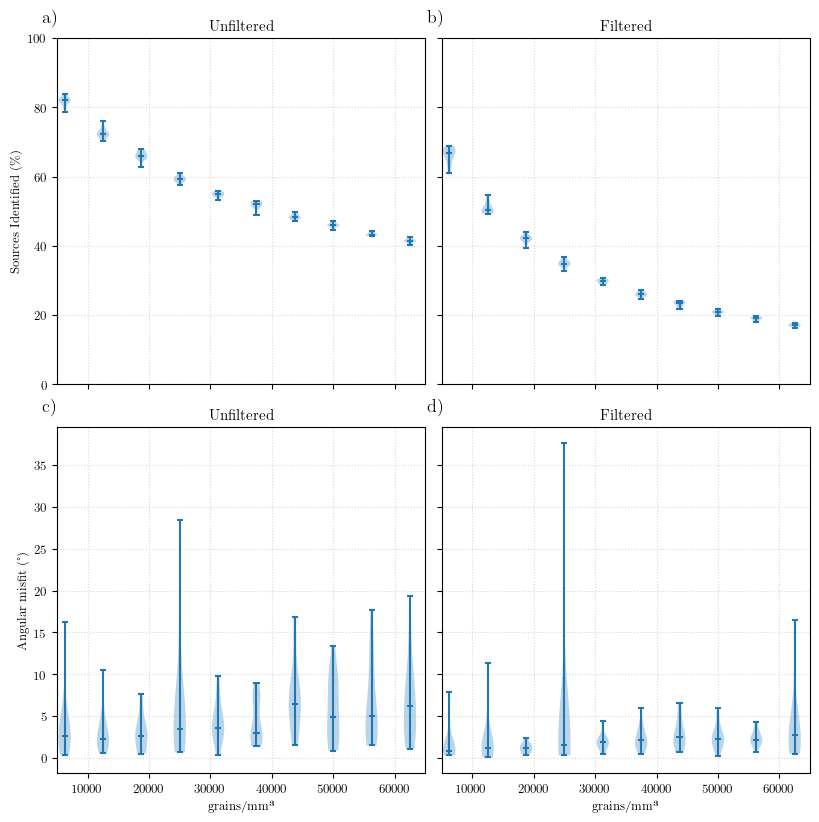

In [33]:
with plt.rc_context(mpl_rc):
    fig, axes = plt.subplots(2, 2, figsize=(8, 8), sharex='col', sharey='row')
    ylabels = ([r'Sources Identified (\%)', r'', 
                r'Angular misfit (°)', r''])
    parameters = np.array([unfiltered_ident_perc, filtered_ident_perc, unfiltered_misfit, filtered_misfit])
    for ax, letter, ylabel, params in zip(
        axes.ravel(), "a b c d".split(), ylabels, parameters):

#         ax.boxplot(np.array(params), notch=False, positions=(count_sources/volume_mm2), 
#                    widths=1000, flierprops={'marker': '.', 'markersize': 5, 'markerfacecolor': 'k'})

        ax.violinplot(np.array(params), positions=(count_sources/volume_mm2), showmedians=True,
                       widths=2000, showextrema=True, showmeans=False)


        ax.set_ylabel(ylabel)
        ax.grid(alpha=0.5, linestyle=':')
        
    titles = ['Unfiltered', 'Filtered', 'Unfiltered', 'Filtered']
    for ax, letter, title in zip(axes.ravel(), "a b c d".split(), titles):
        ax.text(-0.04, 1.045, f"{letter})", transform=ax.transAxes, fontsize=13)
        ax.set_aspect("auto")
        ax.set_title(title)
        ax.set_xlim(5000, 65000)
    axes.ravel()[0].set_ylim(0, 100)
    axes.ravel()[1].set_ylim(0, 100)
    axes.ravel()[2].set_xlabel('grains/mm³')
    axes.ravel()[3].set_xlabel('grains/mm³')
    plt.tight_layout(pad=0, h_pad=0.8, w_pad=0.4)
#     fig.savefig(fig_dir / "grain_concentration.png", dpi=400, facecolor='w', bbox_inches='tight')
    plt.show()

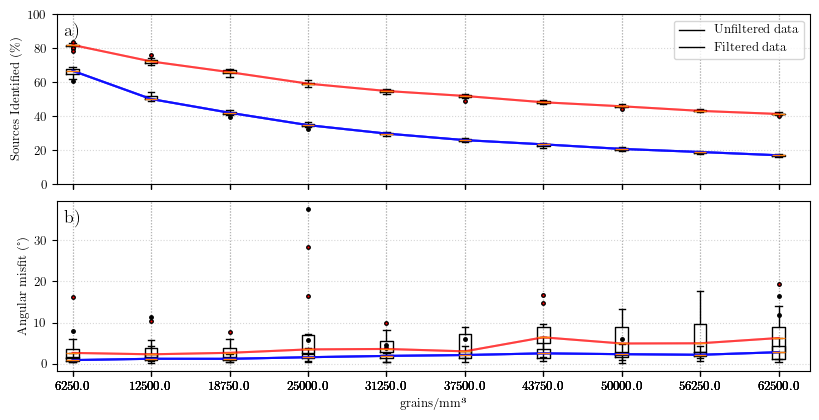

In [34]:
with plt.rc_context(mpl_rc):
    fig, axes = plt.subplots(2, 1, figsize=(8, 4), sharex='col')
    ylabels = ([r'Sources Identified (\%)', 
                r'Angular misfit (°)'])
    parameters_unfiltered = np.array([unfiltered_ident_perc, unfiltered_misfit]) #np.zeros(shape)])
    parameters_filtered = np.array([filtered_ident_perc, filtered_misfit])
    for ax, letter, ylabel, params1, params2 in zip(
        axes.ravel(), "a b".split(), ylabels, parameters_unfiltered, parameters_filtered):
        
#         if ax:
        bplot1 = ax.boxplot(np.array(params1), notch=False, positions=(count_sources/volume_mm2), 
                   widths=1000, flierprops={'marker': '.', 'markersize': 5, 'markerfacecolor': 'r'})
        bplot2 = ax.boxplot(np.array(params2), notch=False, positions=(count_sources/volume_mm2), 
                   widths=1000, flierprops={'marker': '.', 'markersize': 5, 'markerfacecolor': 'k'})

        leg = ax.get_legend()


#         ax.violinplot(np.array(params2), positions=(count_sources/volume_mm2), showmedians=True,
#                        widths=2000, showextrema=True, showmeans=False)
        medians1 = [item.get_ydata() for item in bplot1['medians']]
        ax.plot((count_sources/volume_mm2), medians1, alpha=0.5, color='r', label='Filtered data')

 
        medians2 = [item.get_ydata() for item in bplot2['medians']]
        ax.plot((count_sources/volume_mm2), medians2, alpha=0.5, color='b', label='Filtered data')
        
#         ax.violinplot(np.array(params1), positions=(count_sources/volume_mm2), showmedians=True,
#                        widths=2000, showextrema=True, showmeans=False)  
#         ax.violinplot(np.array(params2), positions=(count_sources/volume_mm2), showmedians=True,
#                        widths=2000, showextrema=True, showmeans=False)  
        
#         else:

            
#             bplot2 = ax.boxplot(np.array(params2), notch=False, positions=(count_sources/volume_mm2), 
#                        widths=1000, flierprops={'marker': '.', 'markersize': 5, 'markerfacecolor': 'k'})
    

#             q1_values = [item.get_ydata()[0] for item in bplot2['boxes']]
#             q3_values = [item.get_ydata()[2] for item in bplot2['boxes']]
            
#             ax.plot((count_sources/volume_mm2), q1_values, alpha=0.5, color='b')
#             ax.plot((count_sources/volume_mm2), q1_values, alpha=0.5, color='b')
            
#             ax.fill_between((count_sources/volume_mm2), q1_values, q3_values, color='gray', alpha=0.5)


        medians2 = [item.get_ydata() for item in bplot2['medians']]
        ax.plot((count_sources/volume_mm2), medians2, alpha=0.5, color='b', label='Filtered data')       

        
        ax.set_ylabel(ylabel)
        ax.grid(alpha=0.5, linestyle=':')
        
    titles = ['Unfiltered', 'Filtered', 'Unfiltered', 'Filtered']
    for ax, letter, title in zip(axes.ravel(), "a b c d".split(), titles):
#         ax.text(-0.04, 1.045, f"{letter})", transform=ax.transAxes, fontsize=13)
        ax.text(0.01, 0.87, f"{letter})", transform=ax.transAxes, fontsize=13)
        ax.set_aspect("auto")
        

#         ax.set_title(title)
        
    axes.ravel()[0].set_ylim(0, 100)
#     axes.ravel()[1].set_ylim(0, 30)

    axes.ravel()[1].set_xlabel('grains/mm³')
    axes.ravel()[1].set_xlim(5000, 65000)
    axes.ravel()[0].set_xlim(5000, 65000)
    

    axes.ravel()[0].legend(['Unfiltered data', 'Filtered data'])
    
    
#     axes.ravel()[3].set_xlabel('grains/mm²')
    plt.tight_layout(pad=0, h_pad=0.8, w_pad=0.4)
    fig.savefig(fig_dir / "grain_concentration.png", dpi=400, facecolor='w', bbox_inches='tight')
    plt.show()

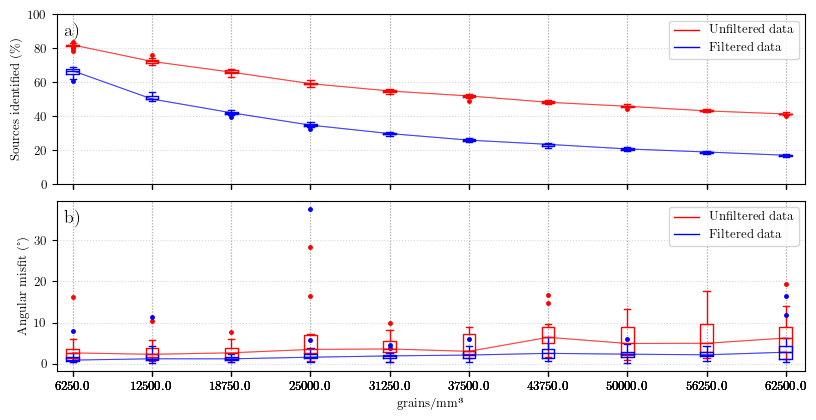

In [35]:
from matplotlib.lines import Line2D
with plt.rc_context(mpl_rc):
    fig, axes = plt.subplots(2, 1, figsize=(8, 4), sharex='col')
    ylabels = ([r'Sources identified (\%)', 
                r'Angular misfit (°)'])
    parameters_unfiltered = np.array([unfiltered_ident_perc, unfiltered_misfit]) #np.zeros(shape)])
    parameters_filtered = np.array([filtered_ident_perc, filtered_misfit])
    for ax, letter, ylabel, params1, params2 in zip(
        axes.ravel(), "a b".split(), ylabels, parameters_unfiltered, parameters_filtered):
        
        color_bplot1 = 'red'
        color_bplot2 = 'blue'

        bplot1 = ax.boxplot(np.array(params1), notch=False, positions=(count_sources/volume_mm2), 
                           widths=1000, flierprops={'marker': '.', 'markersize': 5, 'markerfacecolor': color_bplot1,
                                                    'markeredgecolor': color_bplot1,},
                           boxprops=dict(color=color_bplot1), whiskerprops=dict(color=color_bplot1),
                           capprops=dict(color=color_bplot1), medianprops=dict(color=color_bplot1))  

        bplot2 = ax.boxplot(np.array(params2), notch=False, positions=(count_sources/volume_mm2), 
                           widths=1000, flierprops={'marker': '.', 'markersize': 5, 'markerfacecolor': color_bplot2,
                                                    'markeredgecolor': color_bplot2,},
                           boxprops=dict(color=color_bplot2), whiskerprops=dict(color=color_bplot2),
                           capprops=dict(color=color_bplot2), medianprops=dict(color=color_bplot2))  

        # Configurating legend colors
        legend_elements = [Line2D([0], [0], color=color_bplot1, lw=1, label='Unfiltered data'),
                           Line2D([0], [0], color=color_bplot2, lw=1, label='Filtered data')]

        # Add legend
        ax.legend(handles=legend_elements)


        medians1 = [item.get_ydata() for item in bplot1['medians']]
        ax.plot((count_sources/volume_mm2), medians1, linewidth=0.75, alpha=0.5, color='r', label='Filtered data')

 
        medians2 = [item.get_ydata() for item in bplot2['medians']]
        ax.plot((count_sources/volume_mm2), medians2, linewidth=0.75, alpha=0.5, color='b', label='Filtered data')


        
        ax.set_ylabel(ylabel)
        ax.grid(alpha=0.5, linestyle=':')
        

    for ax, letter, title in zip(axes.ravel(), "a b".split(), titles):
        ax.text(0.01, 0.87, f"{letter})", transform=ax.transAxes, fontsize=13)
        ax.set_aspect("auto")

        
    axes.ravel()[0].set_ylim(0, 100)

    axes.ravel()[1].set_xlabel('grains/mm³')
    axes.ravel()[1].set_xlim(5000, 64000)
    axes.ravel()[0].set_xlim(5000, 64000)

    plt.tight_layout(pad=0, h_pad=0.8, w_pad=0.4)
    fig.savefig(fig_dir / "grain_concentration.png", dpi=400, facecolor='w', bbox_inches='tight')
    plt.show()